In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [ ]:
def clean(df):
  # Fill missing values
  df.fillna(method='ffill', limit=3, inplace=True)
  df.fillna(method='bfill', inplace=True)

  # Remove outliers using Z-Score, standard threshold of 3
  threshold = 3

  for ticker in df.columns:
      z_scores = np.abs((df[ticker] - df[ticker].mean()) / df[ticker].std())
      df.loc[z_scores > threshold, ticker] = np.nan

  # Remove any rows where all values are NaN after outlier removal
  df.dropna(how='all', inplace=True)

  # Fill any new NaNs created by outlier removal
  df.fillna(method='ffill', inplace=True)
  df.fillna(method='bfill', inplace=True)

  return df

ticker = 'TSLA'

end_date = datetime.now()
start_date = end_date - timedelta(365)

data = pd.DataFrame(yf.download(ticker, start=start_date, end=end_date, auto_adjust=True).Close)

cleaned_data = clean(data)
display(cleaned_data)

[*********************100%%**********************]  1 of 1 completed


,Close
Date,
2023-07-12,271.989990
2023-07-13,277.899994
2023-07-14,281.380005
2023-07-17,290.380005
2023-07-18,293.339996
...,...
2024-07-03,246.389999
2024-07-05,251.520004
2024-07-08,252.940002


In [ ]:
window = 20
# Here we get the 20 day MA to make our Bollinger Bands
n_std_dev = 2

cleaned_data[f'{ticker}_20_MA'] = cleaned_data['Close'].rolling(window=window).mean()
cleaned_data[f'{ticker}_Std_Dev'] = cleaned_data['Close'].rolling(window=window).std()
cleaned_data[f'{ticker}_Upper_Band'] = cleaned_data[f'{ticker}_20_MA'] + (cleaned_data[f'{ticker}_Std_Dev'] * n_std_dev)
cleaned_data[f'{ticker}_Lower_Band'] = cleaned_data[f'{ticker}_20_MA'] - (cleaned_data[f'{ticker}_Std_Dev'] * n_std_dev)


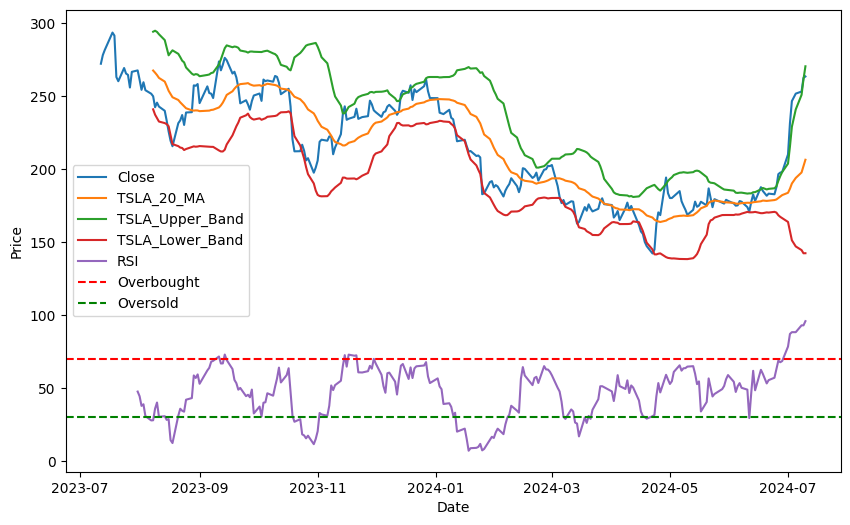

In [ ]:
# Use RSI with Bollinger Bands for more accurate signals
rsi_window = 14

delta = cleaned_data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=rsi_window).mean()
avg_loss = loss.rolling(window=rsi_window).mean()
rs = avg_gain/avg_loss
rsi = 100 - (100 / (1 + rs))

cleaned_data['RSI'] = rsi

plt.figure(figsize=(10, 6))

for column in cleaned_data.columns:
  if column != f'{ticker}_Std_Dev':
    plt.plot(cleaned_data.index, cleaned_data[column], label=column)

plt.xlabel('Date')
plt.ylabel('Price')
plt.axhline(y=70, color='red', linestyle='--', label='Overbought')
plt.axhline(y=30, color='green', linestyle='--', label='Oversold')
plt.legend()
plt.show()

In [ ]:
cleaned_data['Buy Signal'] = np.where((cleaned_data.Close < cleaned_data[f'{ticker}_Lower_Band']) & (cleaned_data['RSI'] < 30), 1, 0)
cleaned_data['Sell Signal'] = np.where((cleaned_data.Close > cleaned_data[f'{ticker}_Upper_Band']) & (cleaned_data['RSI'] > 70), -1, 0)
cleaned_data['Signal'] = cleaned_data['Buy Signal'] + cleaned_data['Sell Signal']

In [ ]:
display(cleaned_data)

,Close,TSLA_20_MA,TSLA_Std_Dev,TSLA_Upper_Band,TSLA_Lower_Band,RSI,Buy Signal,Sell Signal,Signal
Date,,,,,,,,,
2023-07-12,271.989990,NaN,NaN,NaN,NaN,NaN,0,0,0
2023-07-13,277.899994,NaN,NaN,NaN,NaN,NaN,0,0,0
2023-07-14,281.380005,NaN,NaN,NaN,NaN,NaN,0,0,0
2023-07-17,290.380005,NaN,NaN,NaN,NaN,NaN,0,0,0
2023-07-18,293.339996,NaN,NaN,NaN,NaN,NaN,0,0,0
...,...,...,...,...,...,...,...,...,...
2024-07-03,246.389999,189.931499,19.433082,228.797663,151.065336,88.126247,0,-1,-1
2024-07-05,251.520004,193.757500,23.455083,240.667666,146.847334,88.119691,0,-1,-1
2024-07-08,252.940002,197.507500,26.580368,250.668235,144.346764,92.802480,0,-1,-1


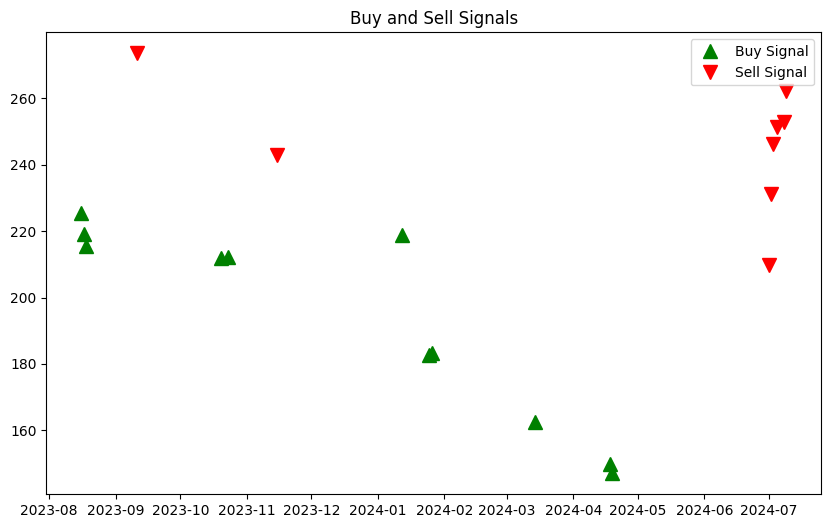

In [ ]:
# Plot buy signals
plt.figure(figsize=(10,6))
plt.plot(cleaned_data.loc[data['Buy Signal'] == 1].index,
         cleaned_data['Close'][cleaned_data['Buy Signal'] == 1],
         '^', markersize=10, color='g', label='Buy Signal')

# Plot sell signals
plt.plot(cleaned_data.loc[cleaned_data['Sell Signal'] == -1].index,
         cleaned_data['Close'][cleaned_data['Sell Signal'] == -1],
         'v', markersize=10, color='r', label='Sell Signal')
plt.title('Buy and Sell Signals')
plt.legend()
plt.show()

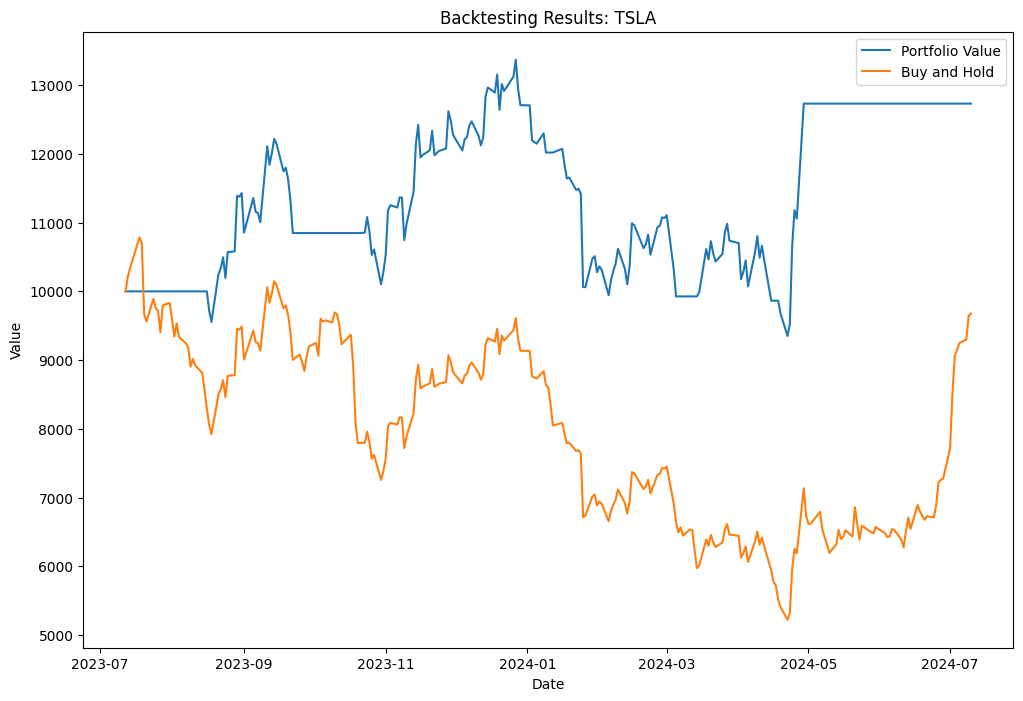

Total Return: 27.32%
Annualized Return: 42.08%
Sharpe Ratio: 0.80


In [ ]:
def backtest(data, initial_capital=10000, stop_loss=-0.1, take_profit=0.25):
    # Create a new DataFrame for the portfolio
    portfolio = pd.DataFrame(index=data.index)
    portfolio['Holdings'] = 0  # Number of shares held
    portfolio['Cash'] = initial_capital  # Initial cash balance
    portfolio['Signal'] = data['Signal']  # Trading signals (buy/sell)
    portfolio['Close'] = data['Close']  # Closing prices

    # Initialize variables
    buy = False  # Flag to indicate if we currently hold a position
    purchase_price = 0  # Purchase price of the current holding
    peak_value = 0  # Peak value of holdings to calculate trailing stop
    trailing_stop = 0  # Trailing stop price

    for i in range(1, len(portfolio)):
        current_close = portfolio['Close'].iloc[i]  # Current close price
        previous_holdings = portfolio['Holdings'].iloc[i-1]  # Holdings from the previous day
        previous_cash = portfolio['Cash'].iloc[i-1]  # Cash balance from the previous day

        if buy:
            # Update peak value and trailing stop if the current value exceeds the peak
            if previous_holdings * current_close > peak_value:
                peak_value = previous_holdings * current_close
                trailing_stop = peak_value * (1 + stop_loss)

            # Check for stop loss or take profit conditions
            current_value = previous_holdings * current_close
            if current_value <= trailing_stop or current_value >= purchase_price * (1 + take_profit):
                # Sell the position due to stop loss or take profit
                portfolio.loc[portfolio.index[i], 'Cash'] = previous_cash + current_value
                portfolio.loc[portfolio.index[i], 'Holdings'] = 0
                buy = False  # Reset buy flag
            else:
                # Hold the position
                portfolio.loc[portfolio.index[i], 'Cash'] = previous_cash
                portfolio.loc[portfolio.index[i], 'Holdings'] = previous_holdings
        else:
            if portfolio['Signal'].iloc[i] == 1:  # Buy signal
                shares_to_buy = previous_cash // current_close  # Calculate number of shares to buy
                purchase_price = shares_to_buy * current_close  # Total purchase price
                portfolio.loc[portfolio.index[i], 'Holdings'] = previous_holdings + shares_to_buy
                portfolio.loc[portfolio.index[i], 'Cash'] = previous_cash - purchase_price
                peak_value = purchase_price  # Initialize peak value
                trailing_stop = peak_value * (1 + stop_loss)  # Initialize trailing stop
                buy = True  # Set buy flag
            elif portfolio['Signal'].iloc[i] == -1:  # Sell signal
                portfolio.loc[portfolio.index[i], 'Cash'] = previous_cash + (previous_holdings * current_close)
                portfolio.loc[portfolio.index[i], 'Holdings'] = 0
            else:  # Hold position
                portfolio.loc[portfolio.index[i], 'Cash'] = previous_cash
                portfolio.loc[portfolio.index[i], 'Holdings'] = previous_holdings

    # Calculate total portfolio value
    portfolio['Total Value'] = portfolio['Holdings'] * portfolio['Close'] + portfolio['Cash']

    # Calculate daily returns
    portfolio['Daily Returns'] = portfolio['Total Value'].pct_change()

    # Calculate cumulative returns
    portfolio['Cumulative Returns'] = (1 + portfolio['Daily Returns']).cumprod()

    return portfolio

# Run the backtest
backtest_results = backtest(cleaned_data)

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(backtest_results.index, backtest_results['Total Value'], label='Portfolio Value')
plt.plot(backtest_results.index, backtest_results['Close'] * (backtest_results['Total Value'].iloc[0] / backtest_results['Close'].iloc[0]), label='Buy and Hold')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title(f'Backtesting Results: {ticker}')
plt.legend()
plt.show()

# Calculate performance metrics
total_return = (backtest_results['Total Value'].iloc[-1] - backtest_results['Total Value'].iloc[0]) / backtest_results['Total Value'].iloc[0]
annualized_return = (1 + total_return) ** (365 / len(backtest_results)) - 1

# 252 is the number of trading days in a year, used to annualize the Sharpe Ratio
sharpe_ratio = np.sqrt(252) * backtest_results['Daily Returns'].mean() / backtest_results['Daily Returns'].std()

print(f"Total Return: {total_return:.2%}")
print(f"Annualized Return: {annualized_return:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
